In [43]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly
from plotly import express as px
from plotly.subplots import make_subplots

import ast

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

# General imports for clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering

# Import for scaling/normalizing data
from sklearn.preprocessing import StandardScaler

# Optional import for dimensionality reduction (if needed)
from sklearn.decomposition import PCA

# Import for evaluating the quality of the clusters (if needed)
from sklearn.metrics import silhouette_score

In [44]:
crimes_ds = pd.read_csv("CrimesOnWomenData.csv")
crimes_ds.head()

,Unnamed: 0,State,Year,Rape,K&A,DD,AoW,AoM,DV,WT
0,0,ANDHRA PRADESH,2001,871,765,420,3544,2271,5791,7
1,1,ARUNACHAL PRADESH,2001,33,55,0,78,3,11,0
2,2,ASSAM,2001,817,1070,59,850,4,1248,0
3,3,BIHAR,2001,888,518,859,562,21,1558,83
4,4,CHHATTISGARH,2001,959,171,70,1763,161,840,0


In [45]:
crimes_ds.shape

(736, 10)

In [46]:
crimes_ds = crimes_ds.drop(columns=['Unnamed: 0', 'AoM'])

In [47]:
# Renaming columns
crimes_ds.rename(columns={
    'Rape': 'Rape',
    'K&A': 'Kidnapping_Abduction',
    'DD': 'Dowry_Deaths',
    'AoW': 'Assault_Women',
    'AoM': 'Assault_Minors',
    'DV': 'Domestic_Violence',
    'WT': 'Women_Trafficking'
}, inplace=True)

In [48]:
crimes_ds['State'] = crimes_ds['State'].str.upper()

In [49]:
# Check all states have equal numbers of entries
crimes_ds['State'].value_counts()

,count
State,
ANDHRA PRADESH,21
UTTAR PRADESH,21
ODISHA,21
PUNJAB,21
RAJASTHAN,21
SIKKIM,21
TAMIL NADU,21
TRIPURA,21
UTTARAKHAND,21


In [50]:
# Replace entries with correct formatting
crimes_ds['State'] = crimes_ds['State'].replace('D & N HAVELI', 'D&N HAVELI')
crimes_ds['State'] = crimes_ds['State'].replace('A & N ISLANDS', 'A&N ISLANDS')

In [51]:
# Drop entries with states that have missing data
crimes_ds = crimes_ds.drop(crimes_ds[(crimes_ds['State'] == 'TELANGANA') | (crimes_ds['State'] == 'DELHI UT')].index)

In [52]:
# Define the regions in India and assign states to them
region_mapping = {
    'North': ['JAMMU & KASHMIR', 'HIMACHAL PRADESH', 'PUNJAB', 'CHANDIGARH', 'UTTARAKHAND', 'HARYANA', 'DELHI', 'DELHI UT', 'UTTAR PRADESH'],
    'South': ['ANDHRA PRADESH', 'KARNATAKA', 'KERALA', 'TAMIL NADU', 'TELANGANA', 'PUDUCHERRY', 'LAKSHADWEEP'],
    'East': ['BIHAR', 'JHARKHAND', 'ODISHA', 'WEST BENGAL'],
    'West': ['RAJASTHAN', 'GUJARAT', 'GOA', 'MAHARASHTRA'],
    'Central': ['MADHYA PRADESH', 'CHHATTISGARH'],
    'North-East': ['ARUNACHAL PRADESH', 'ASSAM', 'MANIPUR', 'MEGHALAYA',
                   'MIZORAM', 'NAGALAND', 'TRIPURA', 'SIKKIM'],
    'Union Territories': ['A&N ISLANDS', 'D&N HAVELI', 'DAMAN & DIU', 'LAKSHADWEEP']
}

# Function to assign regions based on the state name
def assign_region(state):
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'Unknown'  # Default value if the state is not found in any region

# Add a new column 'Region' to the dataset
crimes_ds['Region'] = crimes_ds['State'].apply(assign_region)

# Reorder columns to place 'Region' after 'State'
columns = crimes_ds.columns.tolist()  # Get the list of column names

# Find the index of 'State' and insert 'Region' right after it
state_index = columns.index('State') + 1
columns.insert(state_index, columns.pop(columns.index('Region')))  # Move 'Region' column

# Reorder the dataframe with the new column order
crimes_ds = crimes_ds[columns]


In [53]:
# Checking for missing values
missing_values = crimes_ds.isnull().sum()
missing_values

,0
State,0
Region,0
Year,0
Rape,0
Kidnapping_Abduction,0
Dowry_Deaths,0
Assault_Women,0
Domestic_Violence,0
Women_Trafficking,0


In [54]:
crimes_ds.head()

,State,Region,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,ANDHRA PRADESH,South,2001,871,765,420,3544,5791,7
1,ARUNACHAL PRADESH,North-East,2001,33,55,0,78,11,0
2,ASSAM,North-East,2001,817,1070,59,850,1248,0
3,BIHAR,East,2001,888,518,859,562,1558,83
4,CHHATTISGARH,Central,2001,959,171,70,1763,840,0


In [55]:
# Checking to see each state has even representation across the years

crimes_ds['State'].value_counts()

,count
State,
ANDHRA PRADESH,21
UTTAR PRADESH,21
ODISHA,21
PUNJAB,21
RAJASTHAN,21
SIKKIM,21
TAMIL NADU,21
TRIPURA,21
UTTARAKHAND,21


In [56]:
crimes_ds.describe()

,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
count,714.000000,714.000000,714.00000,714.000000,714.00000,714.000000,714.000000
mean,2011.000000,724.235294,1117.40056,218.375350,1557.77591,2575.046218,28.273109
std,6.059546,983.621236,2001.94923,430.563451,2475.92523,4072.183792,80.040923
min,2001.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,2006.000000,35.000000,24.25000,1.000000,34.25000,13.000000,0.000000
50%,2011.000000,333.500000,282.00000,28.000000,378.00000,651.500000,0.000000
75%,2016.000000,1050.750000,1159.75000,261.750000,1942.00000,3472.250000,13.000000
max,2021.000000,6337.000000,15381.00000,2524.000000,14853.00000,23278.000000,549.000000


<ipython-input-57-673219cfcf4f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = crimes_ds,
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to p

Text(0, 0.5, 'Count of States')

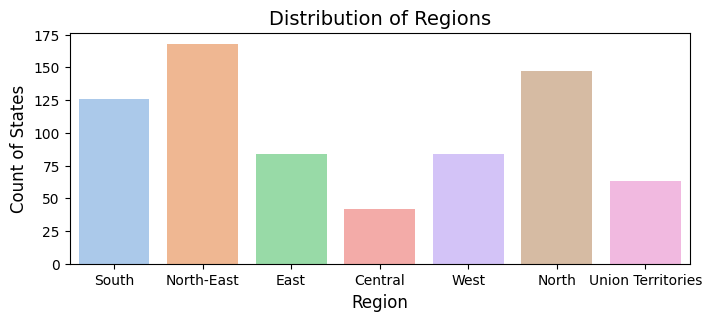

In [57]:
# Distribution of regions
plt.figure(figsize =(8,3))
sns.countplot(data = crimes_ds,
           x = "Region",
             palette="pastel")

# Add title and labels
plt.title('Distribution of Regions', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count of States', fontsize=12)

In [58]:
# Looking at crime proportions by region

# Calculate the total crimes for each region without altering the original dataframe
total_crimes_by_region = crimes_ds.groupby('Region')[['Rape', 'Kidnapping_Abduction', 'Dowry_Deaths', 'Assault_Women', 'Domestic_Violence', 'Women_Trafficking']].sum()

# Create a new dataframe for proportions
crime_proportions_df = total_crimes_by_region.div(total_crimes_by_region.sum(axis=1), axis=0).reset_index()

crime_proportions_df

,Region,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,Central,0.202103,0.152674,0.031172,0.382216,0.230806,0.001029
1,East,0.108430,0.200795,0.054401,0.190727,0.442640,0.003007
2,North,0.114300,0.250348,0.056180,0.208967,0.368341,0.001865
3,North-East,0.109117,0.231278,0.018241,0.228630,0.410301,0.002434
4,South,0.088892,0.092137,0.023516,0.320984,0.461664,0.012807
5,Union Territories,0.113720,0.310193,0.010042,0.274626,0.289706,0.001713
6,West,0.108437,0.147983,0.016379,0.224885,0.497927,0.004389


<Figure size 800x500 with 0 Axes>

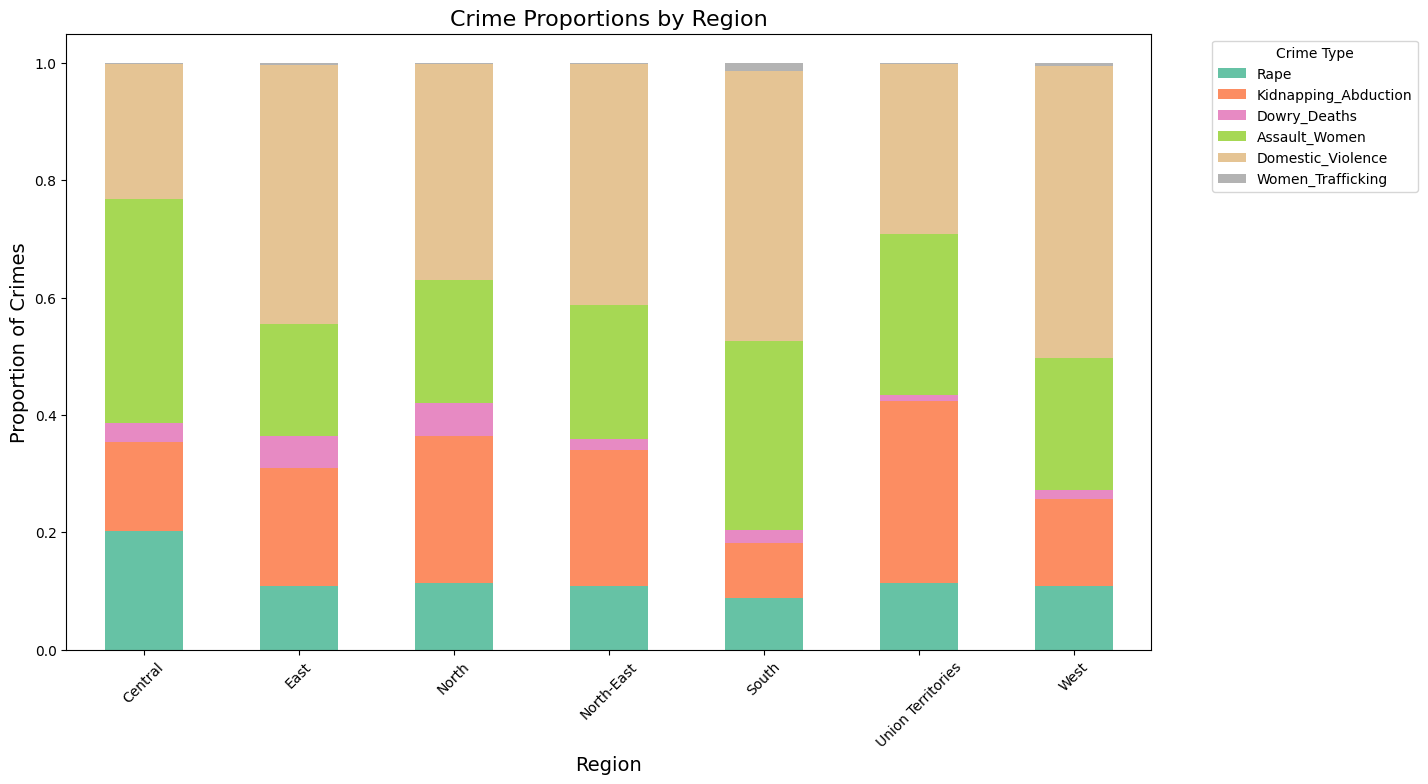

In [59]:
# Visualizing the proportions of crime by region

# Set the figure size
plt.figure(figsize=(8, 5))

# Create a stacked bar plot
crime_proportions_df.set_index('Region').plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2')

# Add titles and labels
plt.title('Crime Proportions by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Proportion of Crimes', fontsize=14)

# Adjust the legend
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Show the plot
plt.show()

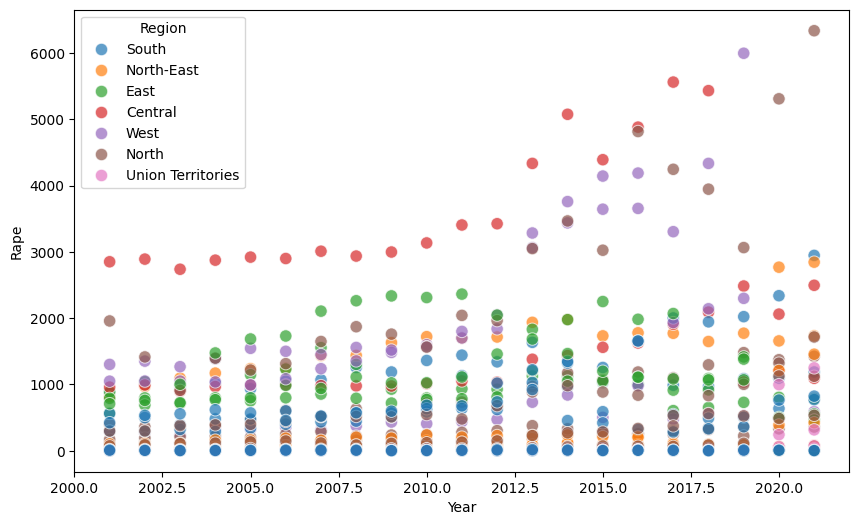

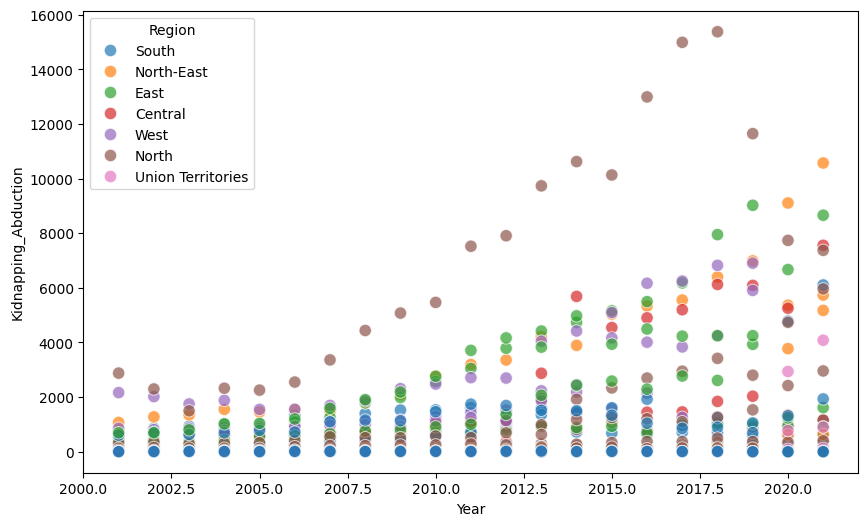

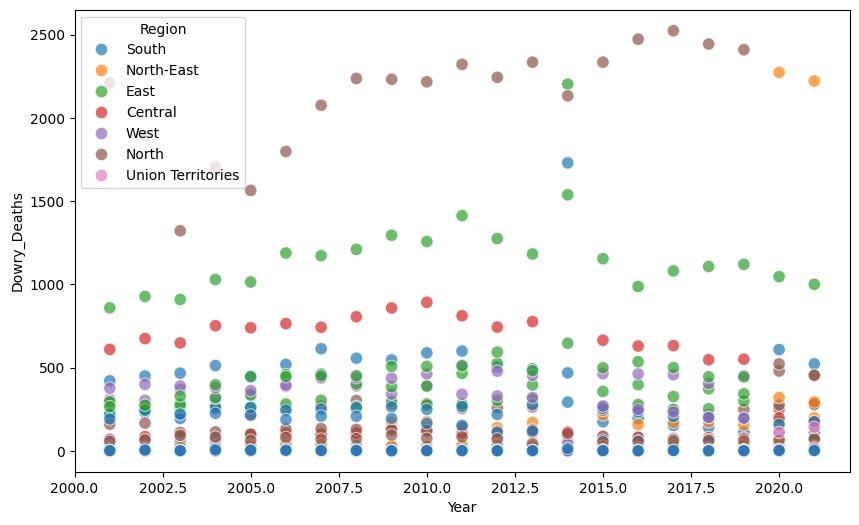

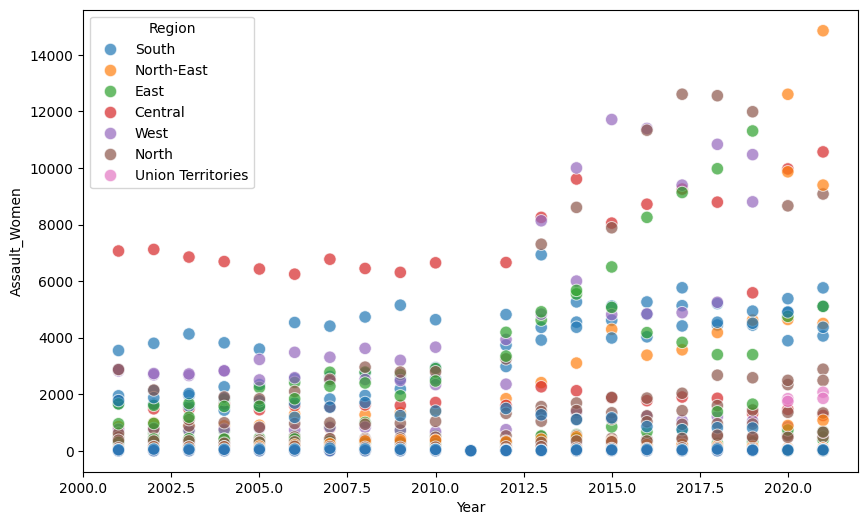

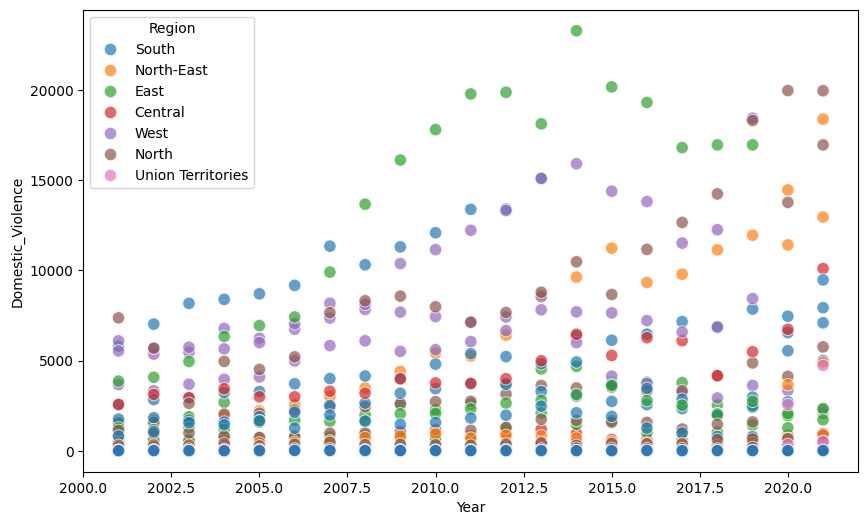

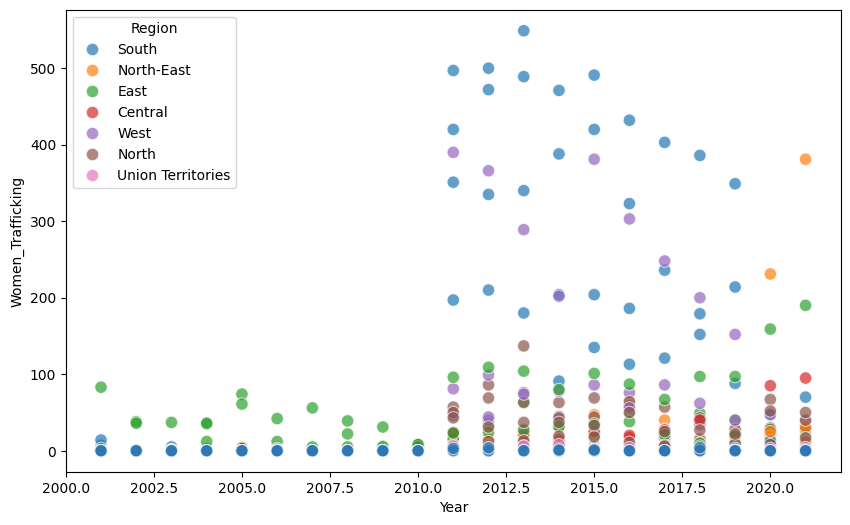

In [60]:
# Crime occurrences by region over time

# List of crime columns to loop through
crime_types = ['Rape', 'Kidnapping_Abduction', 'Dowry_Deaths', 'Assault_Women', 'Domestic_Violence', 'Women_Trafficking']

# Creates new plot for each crime
for crime in crime_types:
    plt.figure(figsize = (10,6))

    sns.scatterplot(data = crimes_ds, x = 'Year',
               y = crime, hue = 'Region', alpha = .7, s=80)

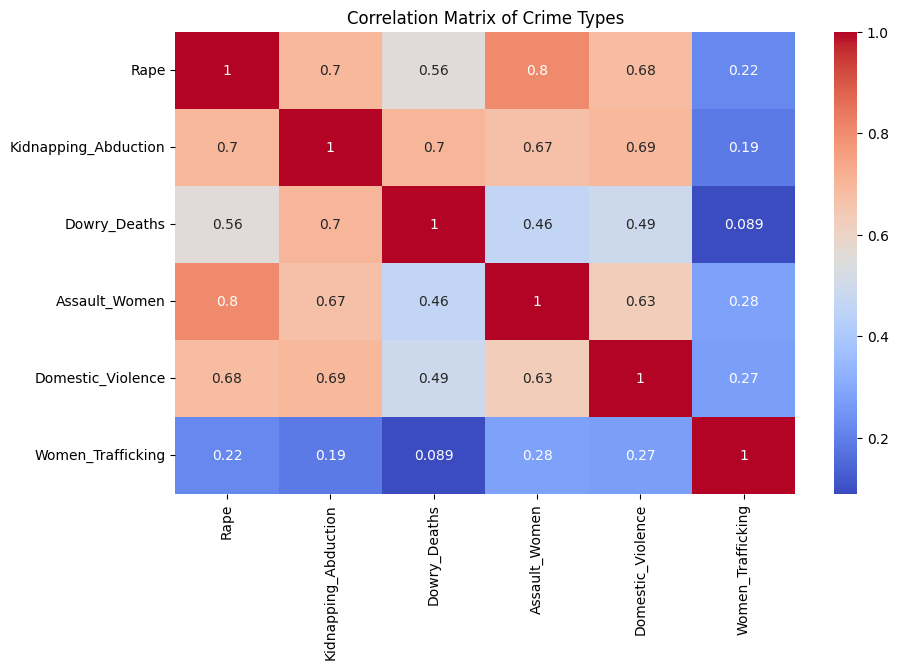

In [61]:
# Calculate correlation matrix
correlation_matrix = crimes_ds[['Rape', 'Kidnapping_Abduction', 'Dowry_Deaths', 'Assault_Women', 'Domestic_Violence', 'Women_Trafficking']].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Crime Types')
plt.show()

In [62]:
crimes_ds.head()

,State,Region,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,ANDHRA PRADESH,South,2001,871,765,420,3544,5791,7
1,ARUNACHAL PRADESH,North-East,2001,33,55,0,78,11,0
2,ASSAM,North-East,2001,817,1070,59,850,1248,0
3,BIHAR,East,2001,888,518,859,562,1558,83
4,CHHATTISGARH,Central,2001,959,171,70,1763,840,0


In [63]:
# Dividing the dataset by years we are interested in

crimes_2001 = crimes_ds[crimes_ds['Year'] == 2001]
crimes_2011 = crimes_ds[crimes_ds['Year'] == 2011]
crimes_2021 = crimes_ds[crimes_ds['Year'] == 2021]

In [64]:
crimes_2001.head()

,State,Region,Year,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
0,ANDHRA PRADESH,South,2001,871,765,420,3544,5791,7
1,ARUNACHAL PRADESH,North-East,2001,33,55,0,78,11,0
2,ASSAM,North-East,2001,817,1070,59,850,1248,0
3,BIHAR,East,2001,888,518,859,562,1558,83
4,CHHATTISGARH,Central,2001,959,171,70,1763,840,0


In [65]:
# Normalize the data
scaler = StandardScaler()

crimes_scaled_2001 = scaler.fit_transform(crimes_2001.iloc[:, 3:])  # Skipping 'State', 'Region', and 'Year' columns
crimes_scaled_2011 = scaler.fit_transform(crimes_2011.iloc[:, 3:])
crimes_scaled_2021 = scaler.fit_transform(crimes_2021.iloc[:, 3:])

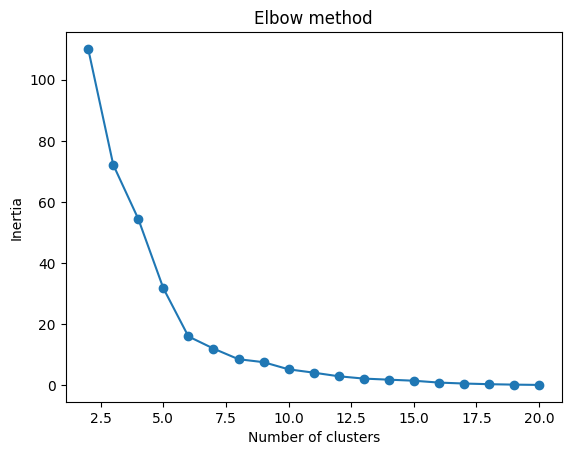

In [66]:
# Elbow method to determine optimal K

sse = []
for k in range(2, 21):
    km = KMeans(n_clusters = k).fit(crimes_scaled_2001)
    sse.append(km.inertia_)

plt.plot(range(2,21), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

<ipython-input-67-2be0a03644a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_2001['Cluster_2001'] = kmeans.fit_predict(crimes_scaled_2001)


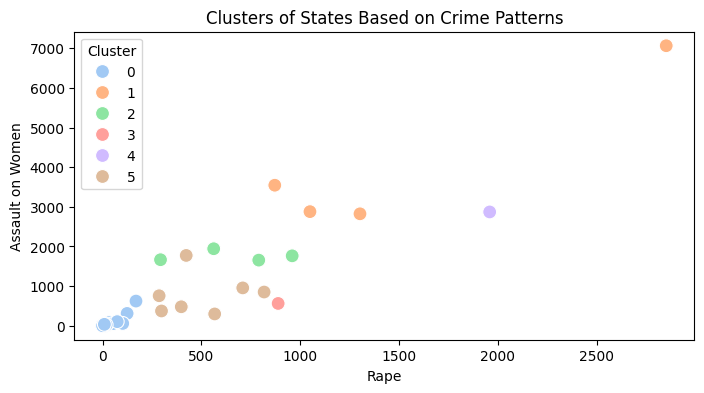

In [67]:
kmeans = KMeans(n_clusters = 6)
crimes_2001['Cluster_2001'] = kmeans.fit_predict(crimes_scaled_2001)

plt.figure(figsize=(8, 4))
sns.scatterplot(x='Rape', y='Assault_Women', hue='Cluster_2001', data=crimes_2001, palette='pastel', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Rape')
plt.ylabel('Assault on Women')
plt.legend(title='Cluster')
plt.show()


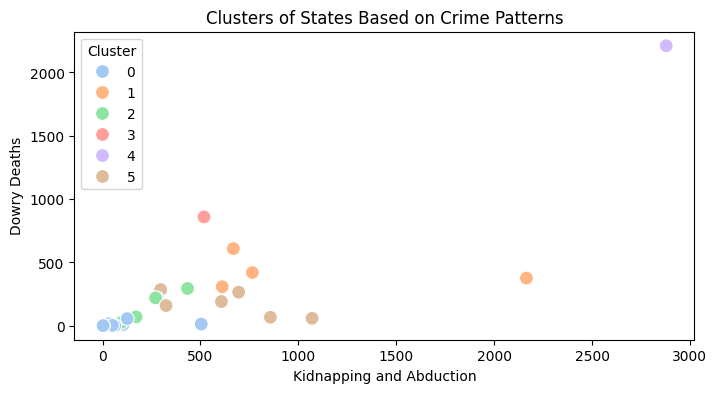

In [68]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Kidnapping_Abduction', y='Dowry_Deaths', hue='Cluster_2001', data=crimes_2001, palette='pastel', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Kidnapping and Abduction')
plt.ylabel('Dowry Deaths')
plt.legend(title='Cluster')
plt.show()

In [69]:
# Display the states grouped by cluster
print(crimes_2001[['State', 'Region','Cluster_2001']].sort_values(by='Cluster_2001'))

                State             Region  Cluster_2001
16          MEGHALAYA         North-East             0
31        DAMAN & DIU  Union Territories             0
30         D&N HAVELI  Union Territories             0
29         CHANDIGARH              North             0
28        A&N ISLANDS  Union Territories             0
26        UTTARAKHAND              North             0
24            TRIPURA         North-East             0
22             SIKKIM         North-East             0
18           NAGALAND         North-East             0
17            MIZORAM         North-East             0
32        LAKSHADWEEP              South             0
15            MANIPUR         North-East             0
33         PUDUCHERRY              South             0
1   ARUNACHAL PRADESH         North-East             0
5                 GOA               West             0
9     JAMMU & KASHMIR              North             0
8    HIMACHAL PRADESH              North             0
13     MAD

Cluster 0: 19 states (7 Northeast, 5 North, 1 West, 1 East, 3 Union Territories, 2 South)
Cluster 1: 3 states (1 South, 2 West)
Cluster 2: 1 state (1 East)
Cluster 3: 1 state (1 North)
Cluster 4: 1 state (1 Central)
Cluster 5: 9 states (3 South, 1 North, 1 Northeast, 2 East, 1 West, 1 Central)

In [70]:
crimes_2001[['Rape','Kidnapping_Abduction','Dowry_Deaths','Assault_Women','Domestic_Violence','Women_Trafficking','Cluster_2001']].groupby('Cluster_2001').mean()

,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
Cluster_2001,,,,,,
0,39.588235,57.235294,5.941176,81.000000,58.705882,0.176471
1,1518.250000,1052.250000,428.250000,4077.000000,4993.750000,2.250000
2,651.000000,243.250000,152.750000,1756.250000,1605.500000,0.000000
3,888.000000,518.000000,859.000000,562.000000,1558.000000,83.000000
4,1958.000000,2879.000000,2211.000000,2870.000000,7365.000000,0.000000
5,499.714286,589.857143,177.571429,782.857143,1816.285714,2.714286


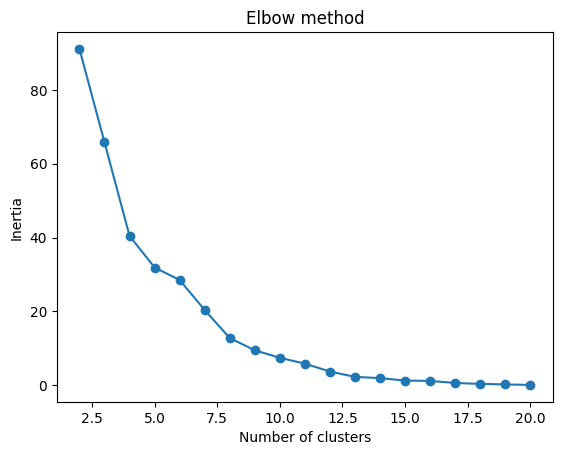

In [71]:
# Elbow method to determine optimal K

sse = []
for k in range(2, 21):
    km = KMeans(n_clusters = k).fit(crimes_scaled_2011)
    sse.append(km.inertia_)

plt.plot(range(2,21), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

<ipython-input-72-84016b3bd8c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_2011['Cluster_2011'] = kmeans.fit_predict(crimes_scaled_2011)


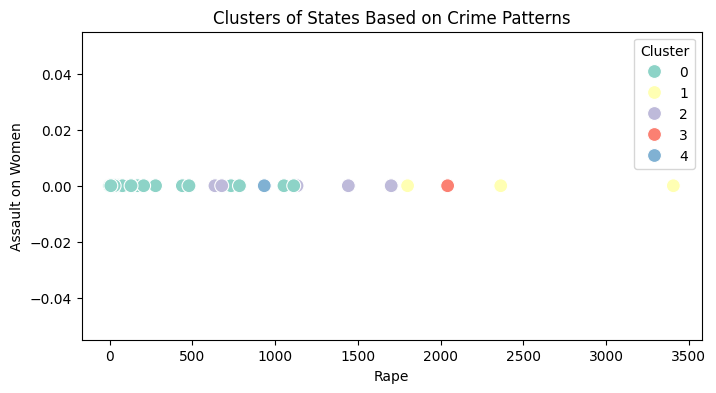

In [72]:
kmeans = KMeans(n_clusters = 5)
crimes_2011['Cluster_2011'] = kmeans.fit_predict(crimes_scaled_2011)

plt.figure(figsize=(8, 4))
sns.scatterplot(x='Rape', y='Assault_Women', hue='Cluster_2011', data=crimes_2011, palette='Set3', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Rape')
plt.ylabel('Assault on Women')
plt.legend(title='Cluster')
plt.show()

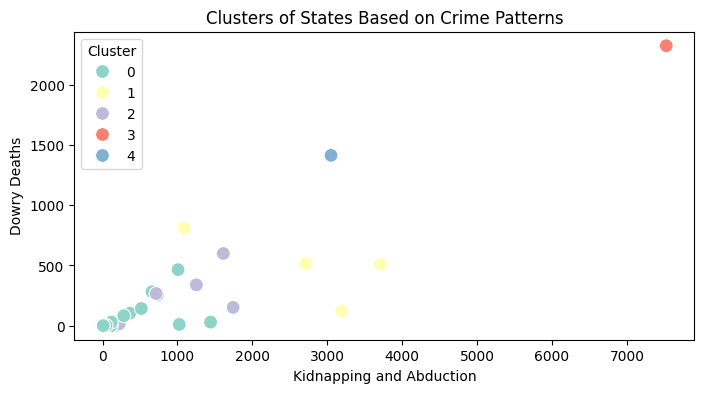

In [73]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Kidnapping_Abduction', y='Dowry_Deaths', hue='Cluster_2011', data=crimes_2011, palette='Set3', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Kidnapping and Abduction')
plt.ylabel('Dowry Deaths')
plt.legend(title='Cluster')
plt.show()


In [74]:
# Display the states grouped by cluster
(crimes_2011[['State', 'Region','Cluster_2011']].sort_values(by='Cluster_2011'))

,State,Region,Cluster_2011
356,MEGHALAYA,North-East,0
372,DAMAN & DIU,Union Territories,0
371,D&N HAVELI,Union Territories,0
370,CHANDIGARH,North,0
369,A&N ISLANDS,Union Territories,0
367,UTTARAKHAND,North,0
365,TRIPURA,North-East,0
362,SIKKIM,North-East,0
360,PUNJAB,North,0
359,ODISHA,East,0


In [75]:
crimes_2011[['Rape','Kidnapping_Abduction','Dowry_Deaths','Assault_Women','Domestic_Violence','Women_Trafficking','Cluster_2011']].groupby('Cluster_2011').mean()

,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
Cluster_2011,,,,,,
0,252.217391,289.478261,61.434783,0.0,671.782609,11.26087
1,2317.250000,2676.000000,489.000000,0.0,10242.000000,55.50000
2,1117.600000,1108.600000,274.400000,0.0,6282.600000,371.00000
3,2042.000000,7525.000000,2322.000000,0.0,7121.000000,43.00000
4,934.000000,3050.000000,1413.000000,0.0,2607.000000,23.00000


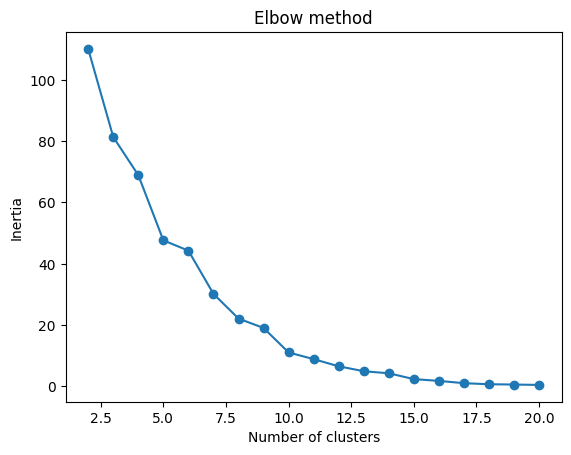

In [76]:
# Elbow method to determine optimal K

sse = []
for k in range(2, 21):
    km = KMeans(n_clusters = k).fit(crimes_scaled_2021)
    sse.append(km.inertia_)

plt.plot(range(2,21), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

<ipython-input-77-11a41c69d8fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_2021['Cluster_2021'] = kmeans.fit_predict(crimes_scaled_2021)


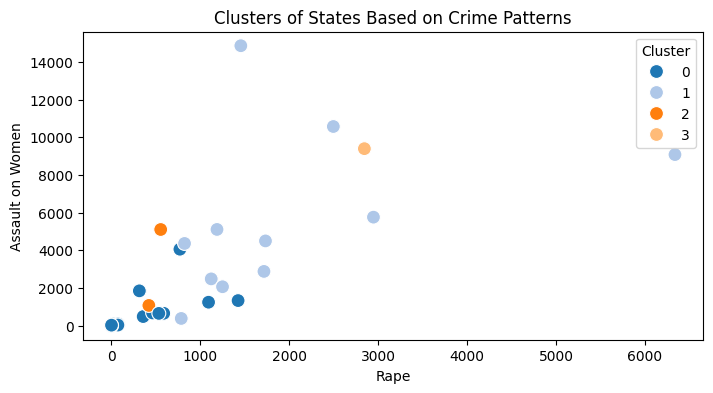

In [77]:
kmeans = KMeans(n_clusters = 4)
crimes_2021['Cluster_2021'] = kmeans.fit_predict(crimes_scaled_2021)

plt.figure(figsize=(8, 4))
sns.scatterplot(x='Rape', y='Assault_Women', hue='Cluster_2021', data=crimes_2021, palette='tab20', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Rape')
plt.ylabel('Assault on Women')
plt.legend(title='Cluster')
plt.show()


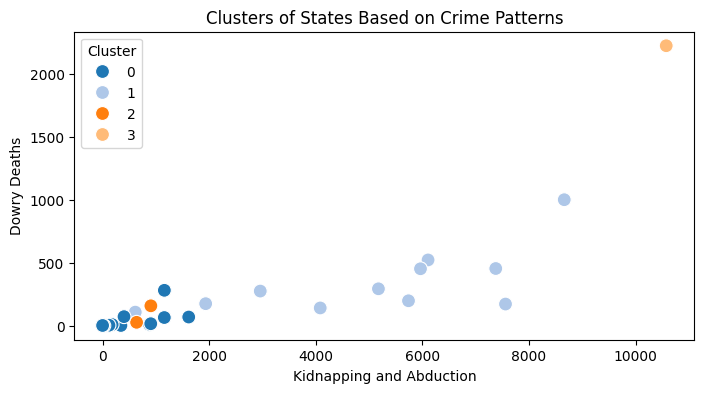

In [78]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Kidnapping_Abduction', y='Dowry_Deaths', hue='Cluster_2021', data=crimes_2021, palette='tab20', s=100)
plt.title('Clusters of States Based on Crime Patterns')
plt.xlabel('Kidnapping and Abduction')
plt.ylabel('Dowry Deaths')
plt.legend(title='Cluster')
plt.show()


In [79]:
# Display the states grouped by cluster
(crimes_2021[['State', 'Region','Cluster_2021']].sort_values(by='Cluster_2021'))

,State,Region,Cluster_2021
716,MEGHALAYA,North-East,0
732,DAMAN & DIU,Union Territories,0
730,CHANDIGARH,North,0
729,A&N ISLANDS,Union Territories,0
728,WEST BENGAL,East,0
726,UTTAR PRADESH,North,0
721,RAJASTHAN,West,0
719,ODISHA,East,0
717,MIZORAM,North-East,0
734,LAKSHADWEEP,South,0


In [80]:
region_cluster_counts = crimes_2021.groupby(['Cluster_2021', 'Region']).size().reset_index(name='Count')
region_cluster_counts

,Cluster_2021,Region,Count
0,0,Central,1
1,0,East,2
2,0,North,4
3,0,North-East,4
4,0,South,3
5,0,Union Territories,2
6,0,West,4
7,1,Central,1
8,1,East,1
9,1,North,3


In [81]:
crimes_2021[['Rape','Kidnapping_Abduction','Dowry_Deaths','Assault_Women','Domestic_Violence','Women_Trafficking','Cluster_2021']].groupby('Cluster_2021').mean()

,Rape,Kidnapping_Abduction,Dowry_Deaths,Assault_Women,Domestic_Violence,Women_Trafficking
Cluster_2021,,,,,,
0,296.850000,348.350000,26.700000,573.600000,620.250000,4.450000
1,1986.818182,5106.181818,344.545455,5641.272727,9261.727273,36.272727
2,488.500000,772.000000,92.500000,3091.000000,1605.500000,285.500000
3,2845.000000,10574.000000,2222.000000,9393.000000,18375.000000,12.000000
